In [1]:
import sys
sys.path.append('/data/test/zhouying/完整交付代码')

In [2]:
import torch
import numpy as np
from utils.plots import ExperimentLogger
from method.clustered.clustered import clustered_fl
from method.my.my import my_fl
from method.my.my import my_fl_suijichouqu
from method.my.my import my_icassp
from method.fedavg.fedavg import fed_avg_fl
from method.fedavg.fedavg import FedAvg_suijichouqu
from method.clustered.clustered import clustered_fl_suijichouqu
from method.ditto.ditto import ditto_fl
from method.ditto.ditto import ditto_fl_suijichouqu
from method.local.local import local_fl

from init_devices import init_clients_and_server
from init_datasets import load_dataset
import argparse
from utils.plots import draw_result_table
torch.cuda.set_device(1)


In [3]:
def parse_args():
    """parse the command line args

    Returns:
        args: a namespace object including args
    """
    parser = argparse.ArgumentParser(description=__doc__)
    parser.add_argument(
        '--dataset',
        help="name of dataset;"
        " possible are `EMNIST`, `FashionMNIST`, `CIFAR10`，`CIFAR100`, `Shakespeare`",
        type=str,
        default='CIFAR10'
    )
    parser.add_argument(
        '--method',
        help = "the method to be used;"
               " possible are `My`,`Clustered`, `FedAvg`, `Ditto`, `Local`, 'Overlap'",
        type=str,
        default='My'
    )
    parser.add_argument(
        '--pathological_split',
        help='if selected, the dataset will be split as in'
             '"Communication-Efficient Learning of Deep Networks from Decentralized Data";'
             'i.e., each client will receive `n_shards` of dataset, where each shard contains at most two classes',
        action='store_true'
    )
    parser.add_argument(
        '--n_shards',
        help='number of shards given to each clients/task; ignored if `--pathological_split` is not used;'
             'default is 2',
        type=int,
        default=2
    )
    parser.add_argument(
        '--n_clients',
        help = "the number of clients",
        type=int,
        default=10
    )
    parser.add_argument(
        '--n_clusters',
        help = "initialize the number of cluster of data distribution",
        type=int,
        default=3
    )
    parser.add_argument(
        '--alpha',
        help = "the parameter of dirichlet",
        type=float,
        default=1.0
    )
    parser.add_argument(
        '--local_epochs',
        help='number of local epochs before communication; default is 1',
        type=int,
        default=1
    )
    parser.add_argument(
        "--n_rounds",
        help="number of communication rounds",
        type=int,
        default=100
    )
    parser.add_argument(
        "--n_sample",
        help="number of sample to use",
        type=int,
        default=20000
    )
    parser.add_argument(
        "--train_frac",
        help="fraction of train samples",
        type=float,
        default=0.8
    )
    parser.add_argument(
        "--val_frac",
        help="fraction of validation samples in train samples",
        type=float,
        default=0
    )   
    parser.add_argument(
        "--seed",
        help='random seed',
        type=int,
        default=42
    )
    args = parser.parse_args()
    return args

In [4]:
# 手动创建 Namespace 对象并设置属性
args = argparse.Namespace(
    dataset='CIFAR10',
    method='PFCAL',
    pathological_split=False,
    n_shards=2,
    n_clients=20,
    n_clusters=3,
    alpha=1.0,
    local_epochs=1,
    n_rounds=100,
    n_sample=40000,
    train_frac=0.8,
    val_frac=0.0,
    seed=42
)

# 将 Namespace 对象转换为字典
args_dict = vars(args)
print(args_dict)

{'dataset': 'CIFAR10', 'method': 'PFCAL', 'pathological_split': False, 'n_shards': 2, 'n_clients': 20, 'n_clusters': 3, 'alpha': 1.0, 'local_epochs': 1, 'n_rounds': 100, 'n_sample': 40000, 'train_frac': 0.8, 'val_frac': 0.0, 'seed': 42}


In [5]:
def flatten(source):
    return torch.cat([value.flatten() for value in source.values()])
def pairwise_angles(sources):
    angles = torch.zeros([len(sources), len(sources)])
    for i, source1 in enumerate(sources):
        for j, source2 in enumerate(sources):
            s1 = flatten(source1)
            s2 = flatten(source2)
            angles[i,j] = torch.sum(s1*s2)/(torch.norm(s1)*torch.norm(s2)+1e-12)
    return angles.numpy()

def compute_pairwise_similarities(clients):
    return pairwise_angles([client.dW for client in clients])

In [6]:
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def Com_clinet(clients,similarities):
    a=deepcopy(clients)
    similarity_matrix = np.array(similarities)  # 确保相似性矩阵已经正确定义和初始化
    # 尝试不同的聚类数目
    best_num_clusters = 2  # 假设2为起始聚类数目
    best_silhouette = -np.inf

    for n_clusters in range(2, 10):  # 尝试从2到9个聚类
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(similarity_matrix)
        
        # 计算轮廓系数
        silhouette_avg = silhouette_score(similarity_matrix, kmeans.labels_)
        
        # 记录最优的聚类数目
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_num_clusters = n_clusters
            best_labels = kmeans.labels_  # 保存当前最优的聚类标签
        
        # print(f"最优的聚类数目是: {best_num_clusters}")
        
        data_points = list(range(len(similarity_matrix)))
        clustered_data_points = {}
        for user, label in zip(data_points, best_labels):
            clustered_data_points.setdefault(label, []).append(user)
        res_idc=[]
        for cluster_id, users in clustered_data_points.items():
            res_idc.append(users)
        print(res_idc)
        return res_idc

In [7]:
def flatten(source):
    return torch.cat([value.flatten() for value in source.values()])
def pairwise_angles(sources):
    angles = torch.zeros([len(sources), len(sources)])
    for i, source1 in enumerate(sources):
        for j, source2 in enumerate(sources):
            s1 = flatten(source1)
            s2 = flatten(source2)
            angles[i,j] = torch.sum(s1*s2)/(torch.norm(s1)*torch.norm(s2)+1e-12)
    return angles.numpy()

def compute_pairwise_similarities(clients):
    return pairwise_angles([client.dW for client in clients])

In [8]:
def run_experiment(args, clients, server,closest_indices):

                
    cfl_stats = ExperimentLogger()

    if args.method == "Clustered":
        clustered_fl(args, clients, server, cfl_stats)
    elif args.method == "Clustered_suijichouqu":
        clustered_fl_suijichouqu(args, clients, server, cfl_stats)
    elif args.method == "My":
        my_fl(args, clients, server, cfl_stats)
    elif args.method == "My_suijichouqu":
        my_fl_suijichouqu(args, clients, server, cfl_stats)    
    elif args.method == "FedAvg":
        fed_avg_fl(args, clients, server, cfl_stats,)
    elif args.method == "Ditto":
        ditto_fl(args, clients, server, cfl_stats)
    elif args.method == "Ditto_suijichouqu":
        ditto_fl_suijichouqu(args, clients, server, cfl_stats)
    elif args.method == "Local":
        local_fl(args, clients, server, cfl_stats)
    elif args.method == "PFCAL":
        PFCAL(args, clients, server, cfl_stats)
    elif args.method == "my_icassp":
        my_icassp(args, clients, server, cfl_stats,closest_indices)
    elif args.method == "FedAvg_suijichouqu":
        FedAvg_suijichouqu(args, clients, server, cfl_stats)
    else:
        raise IOError("possible are `My`,`Clustered`, `FedAvg`, `Ditto`, `Local`, `Overlap`")
    # elif args.method == "Overlap":
    #     overlap_fl(args, clients, server, cfl_stats)

    draw_result_table(args, clients, server)


In [9]:

torch.manual_seed(args.seed)
np.random.seed(args.seed)


dataset, client_train_idcs, client_test_idcs, client_val_idcs, data_info = load_dataset(args)
# print(dataset)
# print(client_train_idcs)
# print(len(client_train_idcs))
# print(len(client_test_idcs))
# print(data_info)
#     # print(dataset[0])
#     # print(client_train_idcs)
#     # print(client_test_idcs)
clients, server = init_clients_and_server(args, dataset, client_train_idcs, client_test_idcs, client_val_idcs, data_info)

#     #Now everything is set up to run our Clustered Federated Learning algorithm. During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

Files already downloaded and verified
Files already downloaded and verified


In [10]:
from numpy.linalg import svd

print(len(client_train_idcs))
# print(np.vstack([torch.flatten(dataset[i][0]) for i in client_train_idcs[0]]))
principal_component_list=[]
for idx in range(args.n_clients):
    # print(np.vstack([torch.flatten(dataset[i][0]) for i in client_train_idcs[0]]))
    matrix=np.vstack([torch.flatten(dataset[i][0]) for i in client_train_idcs[idx]])
    U, S, Vt = svd(matrix)
    principal_component = U[:, 0]
    # print(principal_component)
    principal_component_list.append(principal_component)
    # break

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

n = len(principal_component_list)
similarity_matrix = np.zeros((n, n))

# 计算第一个主成分向量之间的相似度
for i in range(len(principal_component_list)):
    for j in range(i + 1, len(principal_component_list)):
        sim = cosine_similarity(principal_component_list[i][0:min(len(principal_component_list[i]),len(principal_component_list[j]))], principal_component_list[j][0:min(len(principal_component_list[i]),len(principal_component_list[j]))])
        # print(f"主成分向量 {i} 和 {j} 的相似度: {sim:.4f}")
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim

import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics.pairwise import cosine_similarity

# 将相似度矩阵转换为距离矩阵 (1 - 相似度)
distance_matrix = 1 - similarity_matrix

# 使用层次聚类 (基于距离矩阵)
Z = linkage(distance_matrix, method='average')

# 选择聚类数量，例如3个簇
n_clusters = 2
clusters = fcluster(Z, n_clusters, criterion='maxclust')

# 计算每个簇的质心并找到最接近质心的点
def find_closest_to_centroid_from_similarity(similarity_matrix, labels, n_clusters, num_points=1):
    closest_indices = []  # 存储最接近质心的点的索引
    closest_indices_list=[]
    for cluster_id in range(1, n_clusters + 1):
        # 找到属于该簇的向量索引
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_sim_matrix = similarity_matrix[np.ix_(cluster_indices, cluster_indices)]

        # 计算该簇的质心（通过计算相似度矩阵的均值来近似质心）
        centroid_sim = np.mean(cluster_sim_matrix, axis=0)

        # 计算每个点到质心的相似度，距离最小的点最接近质心
        distances = 1 - centroid_sim

        # 找到距离最小的 num_points 个点，返回它们的原始索引
        closest_idx_in_cluster = np.argsort(distances)[:num_points]
        closest_indices.append(list(cluster_indices[closest_idx_in_cluster]))
        closest_indices_list.extend(list(cluster_indices[closest_idx_in_cluster]))

    return closest_indices,closest_indices_list

# 找到每个簇中最接近质心的点，返回它们的索引
closest_indices,closest_indices_list = find_closest_to_centroid_from_similarity(similarity_matrix, clusters, n_clusters, num_points=10)

# 输出最接近质心的点的索引
print(clusters)
print("最接近质心的点的索引：")
print(closest_indices)

20


/data/test/miniconda3/envs/FL_ZHOUYING/lib/python3.8/site-packages/torchvision/transforms/functional.py:96: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


[1 1 2 2 2 2 2 1 2 2 1 2 1 1 1 2 2 2 1 2]
最接近质心的点的索引：
[[0, 18, 12, 14, 7, 10, 1, 13], [16, 4, 6, 19, 17, 2, 5, 8, 15, 3]]


In [11]:
# from utils.plots import display_train_stats
# from tqdm import tqdm

# def PFCAL(args, clients, server, cfl_stats):

#     EPS_1 = 0.4
#     EPS_2 = 1.6   

#     cluster_indices = [[client_id for client_id in range(len(clients))]]
        
#     # similarities = server.compute_pairwise_similarities(clients)
#     #print(similarities)
#     # 进行n_rounds轮迭代
#     acc_clients = []
#     pbar = tqdm(total=args.n_rounds)
#     client_clusters=[]
    
#     for c_round in range(1, args.n_rounds+1):
#         # print(cluster_indices)
#     # c_round为当前的通信轮数
#         # 初始时需要保证客户端和服务器模型同步
#         if c_round == 1:
#             for client in clients:
#                 client.synchronize_with_server(server)
                
#         participating_clients = server.select_clients(clients, frac=1)
#         participating_clients_1= server.select_clients(clients, frac=0.35)

#         for client in participating_clients:
#             train_stats = client.compute_weight_update(epochs=args.local_epochs)
#             client.reset()
#         max_norm = server.compute_max_update_norm(clients)
#         # 计算某个簇内的client的平均参数范数
#         mean_norm = server.compute_mean_update_norm(clients)
#         similarities = compute_pairwise_similarities(clients)
#         if c_round == 20:
#             res_idc=Com_clinet(clients,similarities)
#             client_clusters = [[clients[i] for i in idcs] for idcs in res_idc]
#             print(client_clusters)
        
#         if c_round < 20:
#             client_clusters = [[clients[i] for i in idcs] for idcs in closest_indices]
        
#         # if client_clusters==[]:
#         #     # print("clients",clients)
#         #     server.aggregate_weight_updates(participating_clients)
#         # else:
#         #     for idx in range(len(client_clusters)):
#         #         server.aggregate_weight_updates(client_clusters[idx])
    
#         if c_round>=20:
#             result = []
#             for group in client_clusters:
#                 matching_clients = [client for client in group if client in participating_clients_1]
#                 if matching_clients:
#                     result.append(matching_clients)
#             print("result",result)
#             server.aggregate_weight_updates(result)
#         else:
#             for idx in range(len(client_clusters)):
#                 server.aggregate_weight_updates(client_clusters[idx])

#         for client in clients:
#             client.synchronize_with_server(server)    

#         acc_clients = [client.evaluate() for client in clients]
#         cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,"rounds" : c_round, "clusters" : cluster_indices})
#         pbar.update(1)
#         display_train_stats(cfl_stats, EPS_1, EPS_2, args.n_rounds)
#     for idc in cluster_indices:    
#         server.cache_model(idc, clients[idc[0]].W, acc_clients)

In [12]:
import numpy as np
from tqdm import tqdm
from utils.plots import display_train_stats, clear_graph_pic_dir

def PFCAL(args, clients, server, cfl_stats):

    EPS_1 = 0.4
    EPS_2 = 1.6   
    mean_norm=0
    max_norm=0
    cluster_indices = [[client_id for client_id in range(len(clients))]]
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    similarities = server.compute_pairwise_similarities(clients)
    server.cache_cluster(cluster_indices, 0)
    #print(similarities)
    # 进行n_rounds轮迭代
    acc_clients = []
    clear_graph_pic_dir()
    pbar = tqdm(total=args.n_rounds)
    for c_round in range(1, args.n_rounds+1):
        # print(cluster_indices)
        # c_round为当前的通信轮数
        # 设置客户端初始化模型
        if c_round == 1:
            for client in clients:
                client.synchronize_with_server(server)
                
        participating_clients = server.select_clients(clients, frac=1.0)

        participating_clients_1 = server.select_clients(clients, frac=0.35)

        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=args.local_epochs)
            client.reset()

        # 现将表示所有clients之间参数相似度的邻接矩阵算好放在这里
        similarities = server.compute_pairwise_similarities(clients)
        #print(similarities)
        # cluster_indices_new = []

        # if c_round <  7 :
        #     # cluster_indices = closest_indices_list
        #     client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
        # if c_round >= 7 and c_round<20:
        #     client_clusters=participating_clients_1
            
        if c_round ==  56:
            res_idc=Com_clinet(clients,similarities)
            client_clusters = [[clients[i] for i in idcs] for idcs in res_idc]
            print(client_clusters)

        # if c_round >= 20 :
        #     result = []
        #     for group in client_clusters:
        #         matching_clients = [client for client in group if client in participating_clients_1]
        #         if matching_clients:
        #             result.append(matching_clients)
        #     print("result",result)
        #     server.aggregate_clusterwise(result)
        # else:
        #     server.aggregate_clusterwise(client_clusters)

        if c_round %2==0 and c_round<=55:
            client_clusters = [[clients[i] for i in idcs] for idcs in [closest_indices[0][0:3],closest_indices[1][0:3]]]
            server.aggregate_clusterwise(client_clusters)
        if c_round %2==1 and c_round<=55:
            client_clusters = [[clients[i] for i in idcs] for idcs in closest_indices]
            # result = []
            # for group in client_clusters:
            #     matching_clients = [client for client in group if client in participating_clients_1]
            #     if matching_clients:
            #         result.append(matching_clients)
            # print("result",result)
            # server.aggregate_clusterwise(result)
            # server.aggregate_clusterwise([participating_clients_1])
        
        if c_round >= 56 :
            result = []
            for group in client_clusters:
                matching_clients = [client for client in group if client in participating_clients_1]
                if matching_clients:
                    result.append(matching_clients)
            print("result",result)
            server.aggregate_clusterwise(result)

        acc_clients = [client.evaluate() for client in clients]

        
        # if c_round < 20:
        #     acc_clients = [client.evaluate() for client in [clients[i] for i in closest_indices]]
        # else:
        #     acc_clients = [client.evaluate() for client in participating_clients_1]
        
        cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                    "rounds" : c_round, "clusters" : cluster_indices})
        
        display_train_stats(cfl_stats, EPS_1, EPS_2, args.n_rounds)
        pbar.update(1)
    for idc in cluster_indices:    
        server.cache_model(idc, clients[idc[0]].W, acc_clients)

In [13]:
# from utils.plots import display_train_stats
# import numpy as np
# from tqdm import tqdm

# def PFCAL(args, clients, server, cfl_stats):
#     EPS_1 = 0.4
#     EPS_2 = 1.6   
#     per_local_epochs = 1
#     lam = 0.1
    
#     cluster_indices = [[client_id for client_id in range(len(clients))]]

#     # 进行n_rounds轮迭代
#     acc_clients = []
#     pbar = tqdm(total=args.n_rounds)    
#     for c_round in range(1, args.n_rounds+1):
#         # print(cluster_indices)
#         # c_round为当前的通信轮数
#         # 初始时需要保证客户端和服务器模型同步
#         if c_round == 1:
#             for client in clients:
#                 client.synchronize_with_server(server)
                
#         participating_clients = server.select_clients(clients, frac=0.35)
#         # participating_clients_1=server.select_clients(clients, frac=0.35)

#         for client in participating_clients:
#             train_stats = client.compute_weight_update(epochs=args.local_epochs)
#             client.reset()
#             train_stats = client.compute_personalized_weight(epochs=per_local_epochs, lam=lam)
        
#         max_norm = server.compute_max_update_norm(clients)
#         # 计算某个簇内的client的平均参数范数
#         mean_norm = server.compute_mean_update_norm(clients)

#         if c_round <  7 :
#             cluster_indices = closest_indices_list
#             client_clusters = [[clients[i] for i in idcs] for idcs in closest_indices]

#         if c_round <  7 :
#             server.aggregate_weight_updates(client_clusters[0])
#         else:
#             server.aggregate_weight_updates(participating_clients)
    
#         for client in clients:
#             client.synchronize_with_server(server)    
        
#         acc_clients = [client.evaluate_per() for client in clients]
        
#         cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
#                     "rounds" : c_round, "clusters" : cluster_indices})
        
#         display_train_stats(cfl_stats, EPS_1, EPS_2, args.n_rounds)
#         pbar.update(1)
        
#     for idc in cluster_indices:    
#         server.cache_model(idc, clients[idc[0]].W, acc_clients)

  0%|          | 0/100 [00:00<?, ?it/s]

  第 1 轮的client平均精度为：0.022460


  1%|          | 1/100 [00:29<47:55, 29.04s/it]

  第 2 轮的client平均精度为：0.091667


  3%|▎         | 3/100 [01:23<44:27, 27.50s/it]

  第 3 轮的client平均精度为：0.091667


  4%|▍         | 4/100 [01:49<43:10, 26.99s/it]

  第 4 轮的client平均精度为：0.091667


  5%|▌         | 5/100 [02:16<42:41, 26.96s/it]

  第 5 轮的client平均精度为：0.091667


  6%|▌         | 6/100 [02:41<41:00, 26.17s/it]

  第 6 轮的client平均精度为：0.096411


  7%|▋         | 7/100 [03:05<39:31, 25.50s/it]

  第 7 轮的client平均精度为：0.096411


  8%|▊         | 8/100 [03:29<38:39, 25.22s/it]

  第 8 轮的client平均精度为：0.090561


  9%|▉         | 9/100 [03:55<38:29, 25.38s/it]

  第 9 轮的client平均精度为：0.090561
  第 10 轮的client平均精度为：0.088683


 11%|█         | 11/100 [04:44<36:47, 24.80s/it]

  第 11 轮的client平均精度为：0.088683


 12%|█▏        | 12/100 [05:09<36:45, 25.06s/it]

  第 12 轮的client平均精度为：0.088206


 13%|█▎        | 13/100 [05:35<36:45, 25.36s/it]

  第 13 轮的client平均精度为：0.088206


 14%|█▍        | 14/100 [06:02<37:02, 25.84s/it]

  第 14 轮的client平均精度为：0.091641


 15%|█▌        | 15/100 [06:30<37:30, 26.48s/it]

  第 15 轮的client平均精度为：0.091641


 16%|█▌        | 16/100 [06:58<37:43, 26.94s/it]

  第 16 轮的client平均精度为：0.088206


KeyboardInterrupt: 

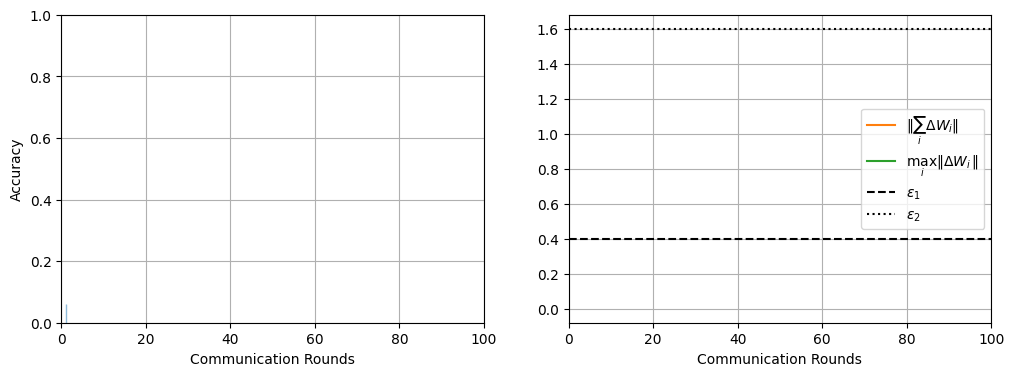

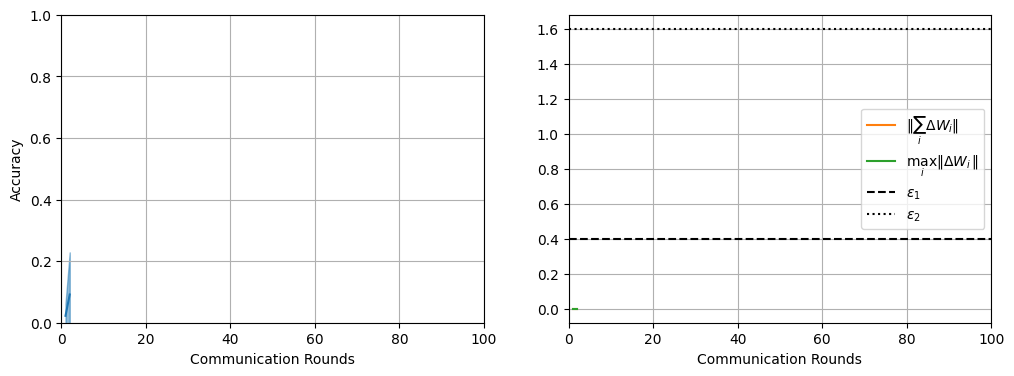

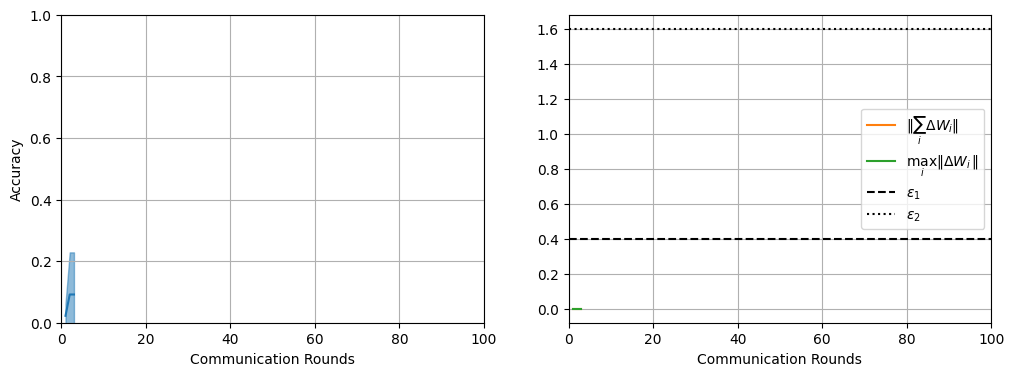

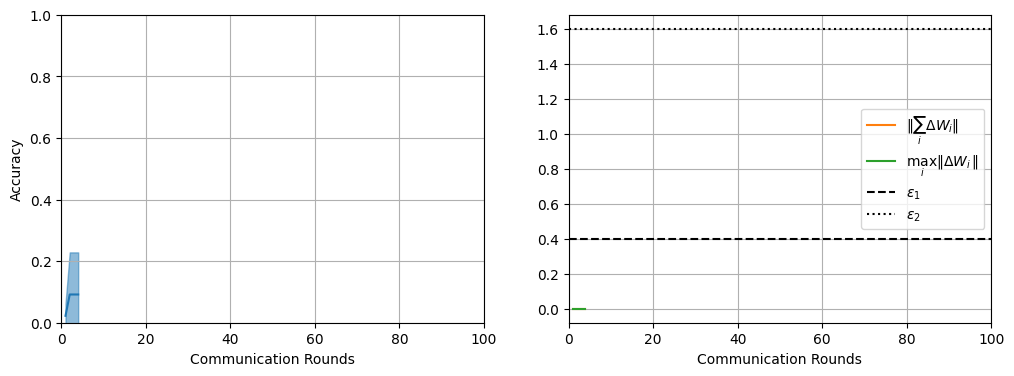

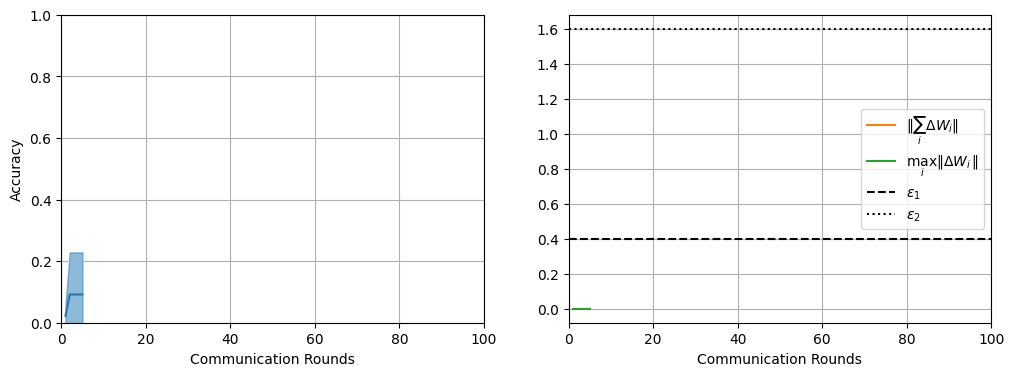

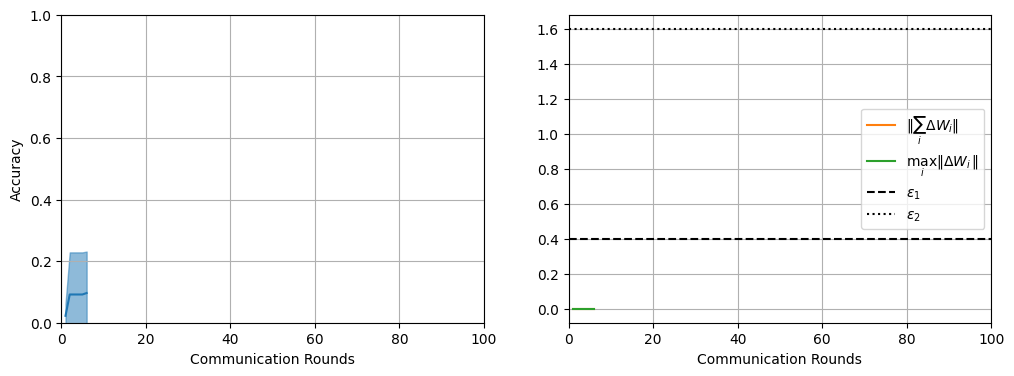

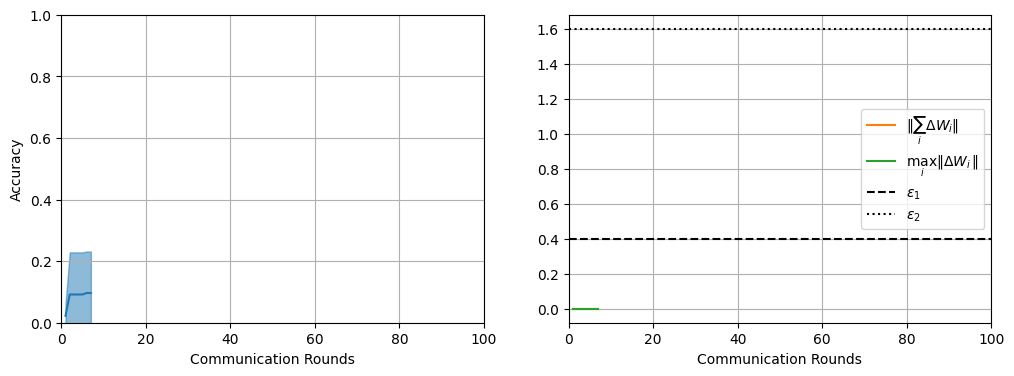

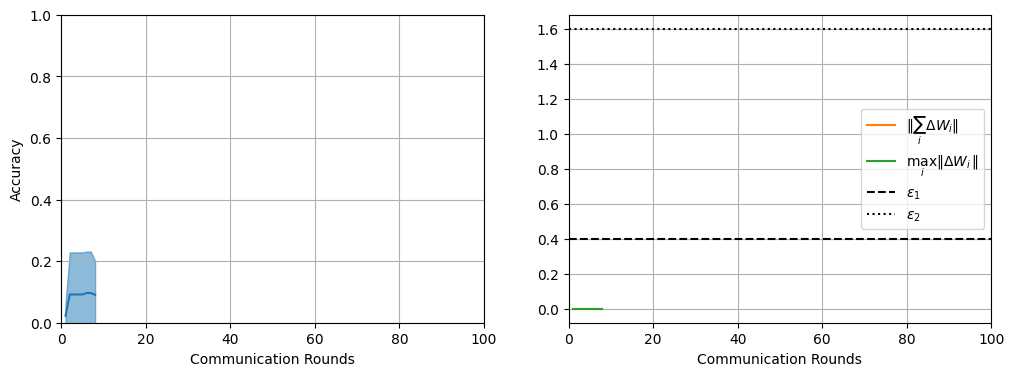

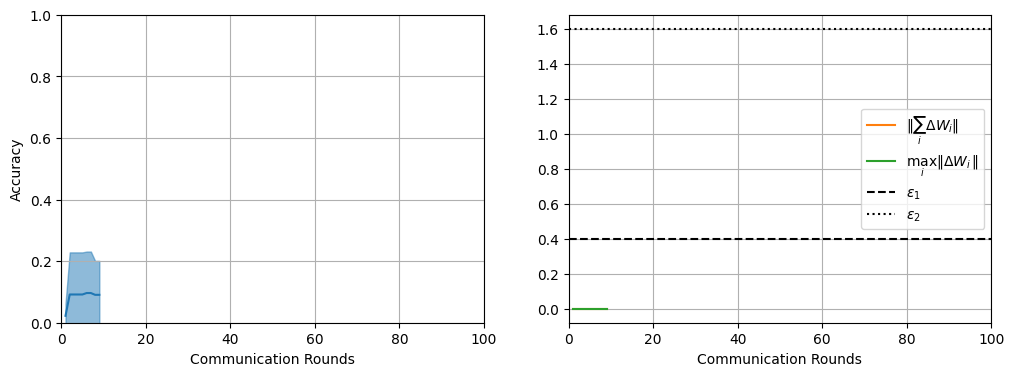

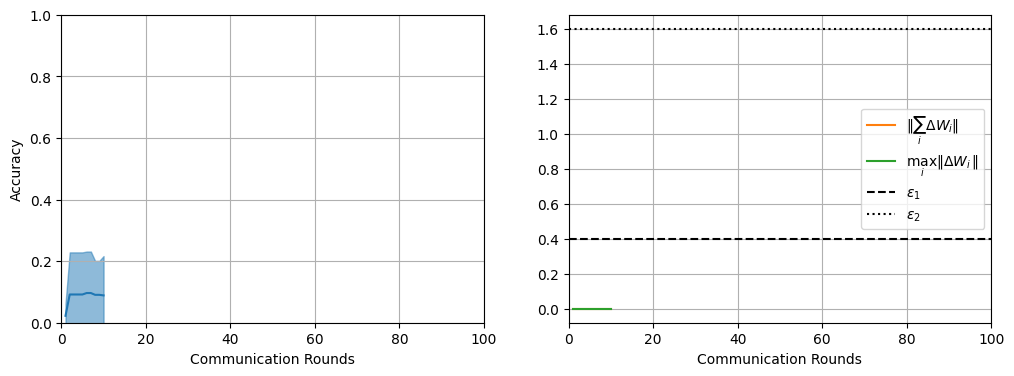

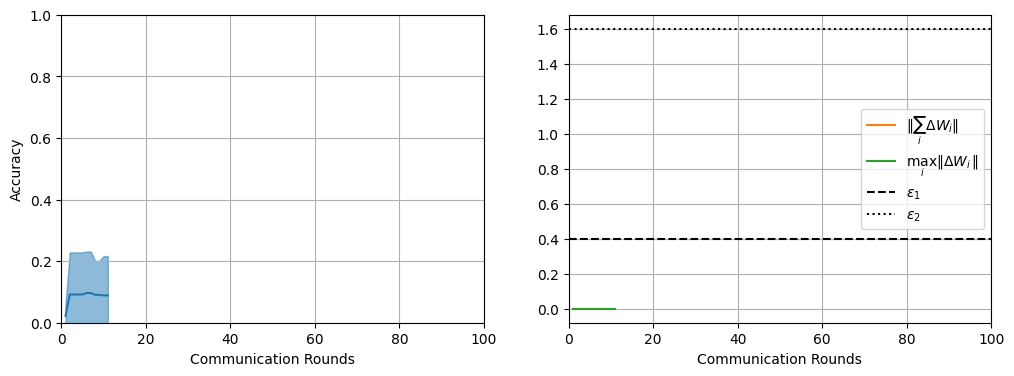

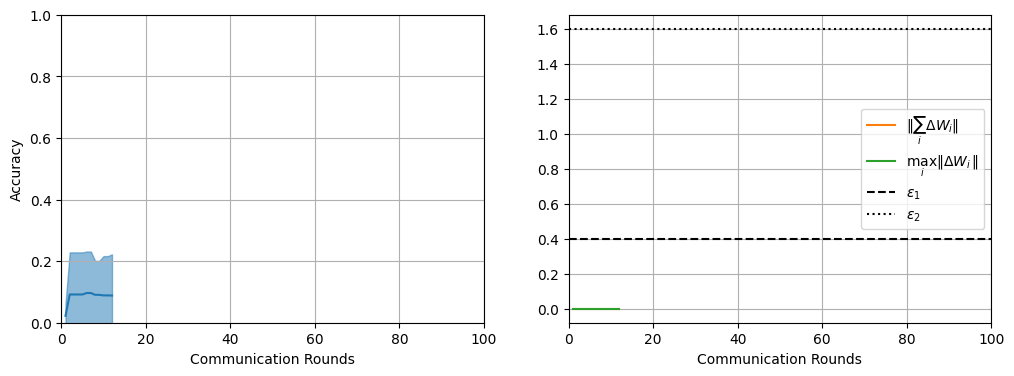

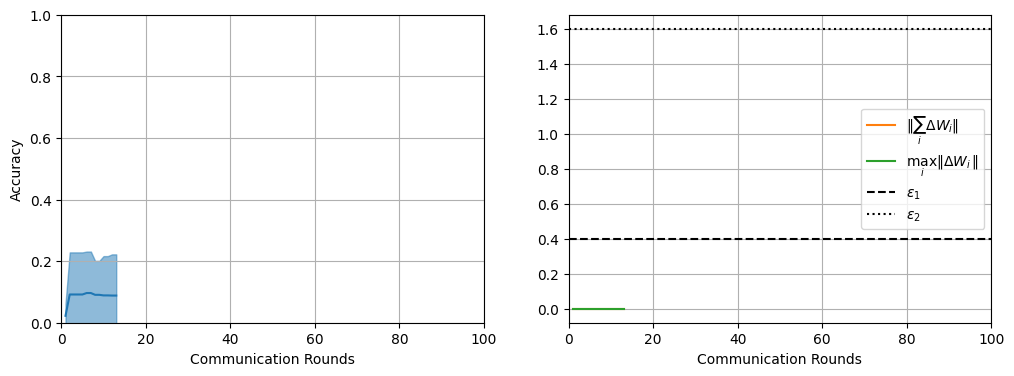

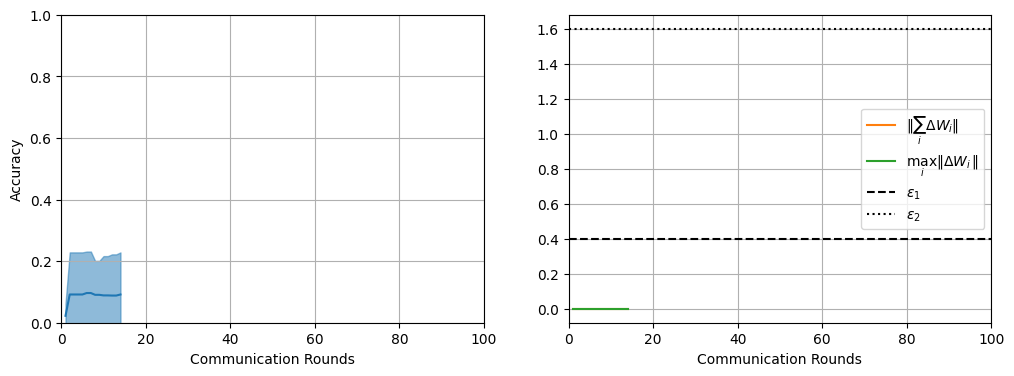

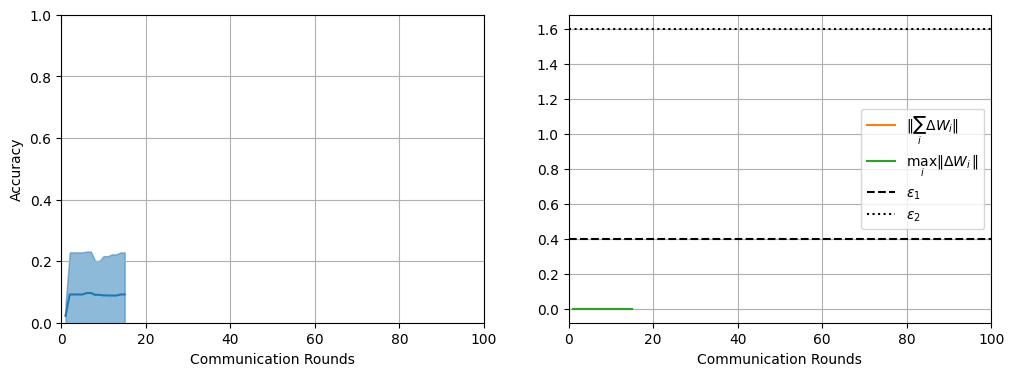

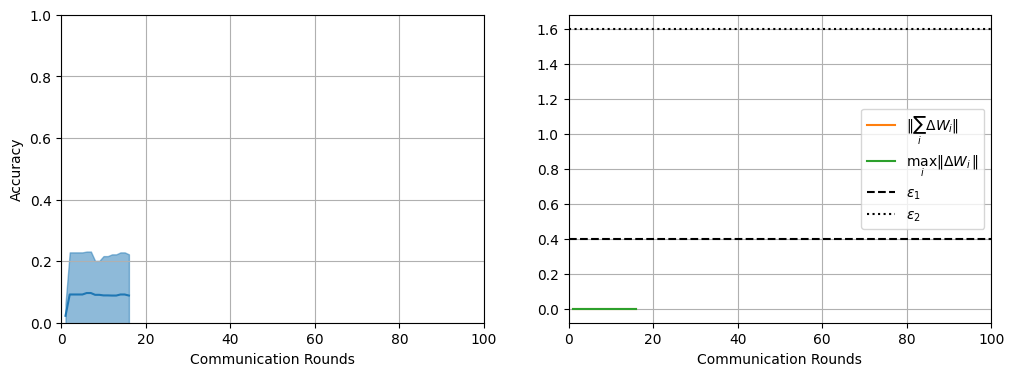

In [14]:
torch.backends.cudnn.enabled = False
run_experiment(args, clients, server,closest_indices)